کتابخانه های استفاده شده 

In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

بررسی فایل‌های موجود داخل پوشه تصاویر و شناسایی باندهای آنها 

In [2]:
# Define the directory path
file_dir = r"C:\Users\Melika\Downloads\ASTER\ASTER"

# List files in the directory
existing_files = os.listdir(file_dir)

# Define ASTER band descriptions for mineral exploration
band_descriptions = {
    1: "Band 4 (SWIR, 1.60-1.70 µm)",
    2: "Band 5 (SWIR, 2.145-2.185 µm)",
    3: "Band 6 (SWIR, 2.185-2.225 µm)",
    4: "Band 7 (SWIR, 2.235-2.285 µm)",
    5: "Band 8 (SWIR, 2.295-2.365 µm)",
    6: "Band 9 (SWIR, 2.360-2.430 µm)"
}

def print_band_info(file_path):
    with rasterio.open(file_path) as src:
        print(f"\nFile: {os.path.basename(file_path)}")
        for band_idx in range(1, src.count + 1):
            description = band_descriptions.get(band_idx, f"Band {band_idx}")
            print(f"  Band {band_idx}: {description}")

print("Existing files in the directory:")
for file in existing_files:
    if file.endswith(".tif"):
        # Construct the full file path
        file_path = os.path.join(file_dir, file)
        
        # Open the file using Rasterio and print metadata and tags
        with rasterio.open(file_path) as src:
            metadata = src.meta
            tags = src.tags()
            
            # Print metadata and tags
            print(f"\nFile: {file}")
            print(f"Metadata: {metadata}")
            print(f"Tags: {tags}")
        
        # Print band information
        print_band_info(file_path)


Existing files in the directory:

File: 1.tif
Metadata: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 9472, 'height': 4713, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, 52.20056217101493,
       0.0, -0.00026949458523585647, 31.971490119455833)}
Tags: {'AREA_OR_POINT': 'Area'}

File: 1.tif
  Band 1: Band 4 (SWIR, 1.60-1.70 µm)
  Band 2: Band 5 (SWIR, 2.145-2.185 µm)
  Band 3: Band 6 (SWIR, 2.185-2.225 µm)
  Band 4: Band 7 (SWIR, 2.235-2.285 µm)
  Band 5: Band 8 (SWIR, 2.295-2.365 µm)
  Band 6: Band 9 (SWIR, 2.360-2.430 µm)

File: 2.tif
Metadata: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2803, 'height': 4713, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, 54.75321488236896,
       0.0, -0.00026949458523585647, 31.971490119455833)}
Tags: {'AREA_OR_POINT': 'Area'}

File: 2.tif
  Band 1: Band 4 (SWIR, 1.60-1.70 µm)
  Band 2: Band 5 (SWIR, 2.145-2.185 µm)
  Band 3:

در این کد اولین تصویر را بارگذاری کرده.
سپس ان را به یک ارایه numpy تبدیل کرده.
این تصویر شامل 6 باند می باشد.
نحوه نمایش ماتریس به صورت 
ارتفاع عرض باند می باشد.

In [2]:
# Define the file path
# file_path = r'E:\uni\project\ASTER\3.tif'
file_path = r'C:\Users\Melika\Downloads\ASTER\ASTER\5.tif'

# Open the TIFF file
with rasterio.open(file_path) as dataset:
    # Read the image data into a numpy array
    image = dataset.read()  # This will be an array of shape (bands, height, width)

# convert to (height, width, bands) shape for easier handling
image_transposed = np.transpose(image, (1, 2, 0))
print("\nTransposed image array shape:", image_transposed.shape)  # (height, width, bands)


Transposed image array shape: (9472, 9472, 6)


نرمال سازی و نمایش تصویر و سه باند اول آن

In [3]:
# Replace NaN, inf, and -inf values with 0 in the image
image_transposed = np.nan_to_num(image_transposed, nan=0, posinf=0, neginf=0)

# Normalize the entire image to [0, 1]
min_val = image_transposed.min()
max_val = image_transposed.max()

if max_val - min_val != 0:
    image_normalized = (image_transposed - min_val) / (max_val - min_val)
else:
    image_normalized = image_transposed  # If all values are the same, avoid division by zero

# Clip values to ensure they are within the range [0, 1]
image_normalized = np.clip(image_normalized, 0, 1)

# Scale the normalized values to the range [0, 255]
image_scaled = image_normalized * 255

# Convert to an unsigned 8-bit integer type
image_uint8 = image_scaled.astype(np.uint8)

# Display the scaled image using the first three bands as RGB (if needed)
# If you want to visualize the RGB composite of the first three bands
image_rgb_uint8 = image_uint8[:, :, :3]  # Only use the first three bands for RGB

# plt.figure(figsize=(10, 10))
# plt.imshow(image_rgb_uint8)
# plt.title('RGB Composite Image (Bands 0, 1, 2)')
# plt.axis('off')  # Hide axis
# plt.show()

ساخت باندهای مورد نیاز

In [4]:
# Assuming image_transposed is defined earlier in the script
band_4 = image_normalized[:, :, 0].astype('float64')
band_5 = image_normalized[:, :, 1].astype('float64')
band_6 = image_normalized[:, :, 2].astype('float64')
band_7 = image_normalized[:, :, 3].astype('float64')
band_8 = image_normalized[:, :, 4].astype('float64')
band_9 = image_normalized[:, :, 5].astype('float64')

# Compute indices with error handling for divisions by zero
with np.errstate(divide='ignore', invalid='ignore'):
    ratio_3_1 = band_6 / band_4
    ratio_4_2 = band_7 / band_5
    ratio_5_4 = band_8 / band_7

    # Compute new indices
    swir_ratio_1 = band_5 / band_4
    swir_ratio_2 = band_6 / band_5
    swir_ratio_3 = band_7 / band_6
    # 
    # fig, ax = plt.subplots(1, 6, figsize=(36, 6))
    # 
    # ax[0].imshow(ratio_3_1, cmap='viridis')
    # ax[0].set_title('Band 6 / Band 4')
    # 
    # ax[1].imshow(ratio_4_2, cmap='viridis')
    # ax[1].set_title('Band 7 / Band 5')
    # 
    # ax[2].imshow(ratio_5_4, cmap='viridis')
    # ax[2].set_title('Band 8 / Band 7')
    # 
    # ax[3].imshow(swir_ratio_1, cmap='viridis')
    # ax[3].set_title('Band 5 / Band 4')
    # 
    # ax[4].imshow(swir_ratio_2, cmap='viridis')
    # ax[4].set_title('Band 6 / Band 5')
    # 
    # ax[5].imshow(swir_ratio_3, cmap='viridis')
    # ax[5].set_title('Band 7 / Band 6')
    # 
    # plt.show()

انتخاب یک سمپل از نقاط غیر صفر

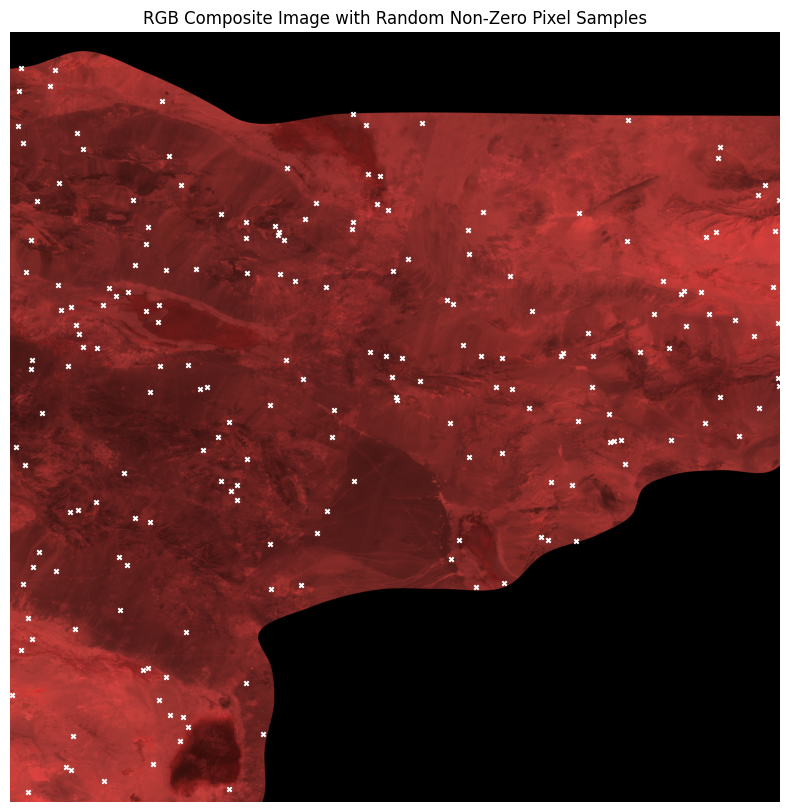

In [5]:
# Create a mask where all RGB bands are non-zero
non_zero_mask = np.all(image_normalized[:, :, :3] != 0, axis=2)

# Get the indices of non-zero pixels
non_zero_indices = np.argwhere(non_zero_mask)

# If there are enough non-zero pixels, randomly select 
if non_zero_indices.shape[0] >= 200:
    selected_indices = non_zero_indices[np.random.choice(non_zero_indices.shape[0], 200, replace=False)]

    # Display the RGB image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb_uint8 )  # Use the RGB composite image created earlier
    plt.title('RGB Composite Image with Random Non-Zero Pixel Samples')
    plt.axis('off')  # Hide axis

    # Plot the selected samples as markers on the image
    plt.scatter(selected_indices[:, 1], selected_indices[:, 0], color='white', marker='x', s=10)  # Smaller 'x' markers

    plt.show()
else:
    print(f"Only {non_zero_indices.shape[0]} non-zero pixels found. Cannot select 100 pixels.")

انتخاب فیچر و اجرای 
kmeans

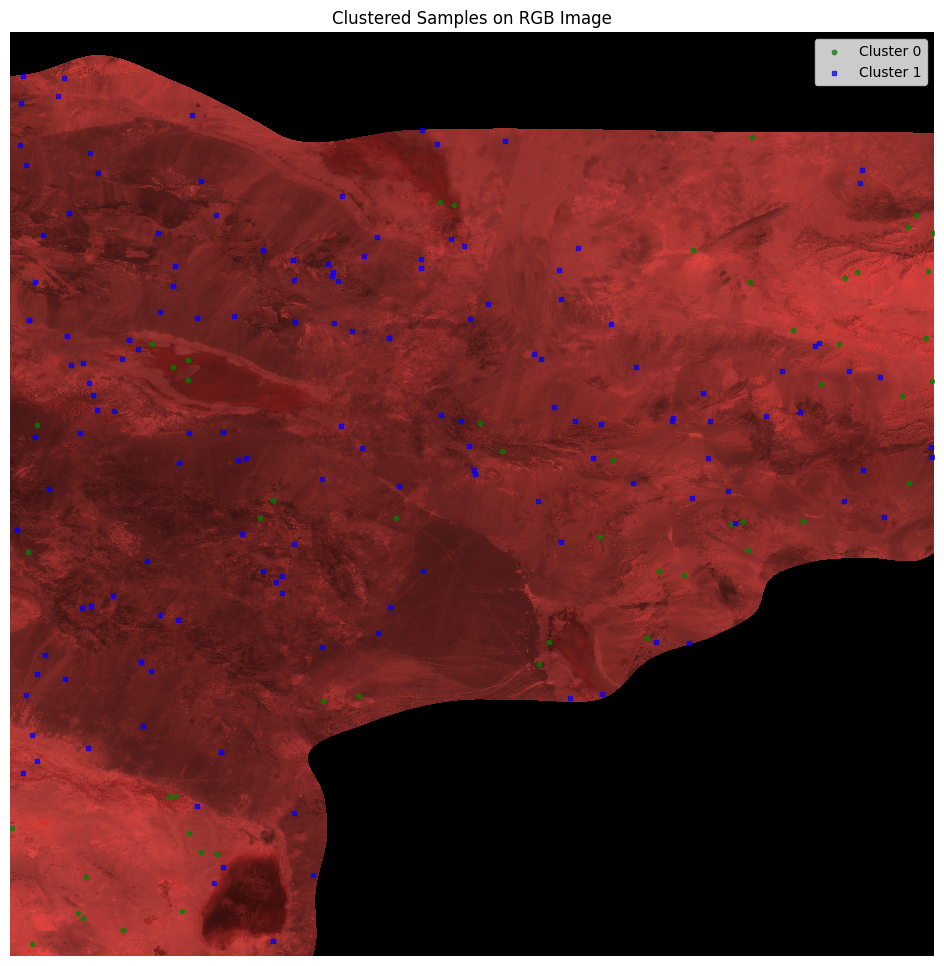

Cluster 0 count: 54
Cluster 0 color: green
Cluster 1 count: 146
Cluster 1 color: blue


In [6]:
# Extract features for the selected pixels
selected_features = np.stack([
    ratio_3_1[selected_indices[:, 0], selected_indices[:, 1]],
    ratio_4_2[selected_indices[:, 0], selected_indices[:, 1]],
    ratio_5_4[selected_indices[:, 0], selected_indices[:, 1]],
    swir_ratio_1[selected_indices[:, 0], selected_indices[:, 1]],
    swir_ratio_2[selected_indices[:, 0], selected_indices[:, 1]],
    swir_ratio_3[selected_indices[:, 0], selected_indices[:, 1]],
], axis=-1)

# Reshape the selected features into a matrix for clustering
X = selected_features.reshape((selected_features.shape[0], -1))  # Flatten last dimension

# Perform k-means clustering into 2 groups
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_

# Create a mask for each cluster
cluster_mask = np.zeros_like(non_zero_mask, dtype=int)
for idx, coord in enumerate(selected_indices):
    cluster_mask[coord[0], coord[1]] = labels[idx] + 1  # Use 1-based index for visualization

# Plot the RGB image with clustered samples
plt.figure(figsize=(12, 12))

# Show the RGB composite image
plt.imshow(image_rgb_uint8, interpolation='none')  # Display the RGB image

# Overlay the cluster samples with different colors and shapes
for cluster_id in range(2):
    cluster_coords = selected_indices[labels == cluster_id]
    plt.scatter(cluster_coords[:, 1], cluster_coords[:, 0], 
                color=['green', 'blue'][cluster_id], 
                marker=['o', 's'][cluster_id],  # Circle and square markers
                label=f'Cluster {cluster_id}', 
                alpha=0.7, s=10)  # Marker size and transparency

plt.title('Clustered Samples on RGB Image')
plt.legend()
plt.axis('off')  # Hide axis
plt.show()

# Print cluster counts and colors
cluster_counts = pd.Series(labels).value_counts()
colors = ['green', 'blue']

for cluster_id in range(2):
    print(f"Cluster {cluster_id} count: {cluster_counts.get(cluster_id, 0)}")
    print(f"Cluster {cluster_id} color: {colors[cluster_id]}")

اجرای مدل

In [7]:
# Prepare data for XGBoost
y = labels
X_features = X  # Use the features from the selected pixels

# Split the data into training and testing sets, while keeping track of the indices
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_features, y, selected_indices, test_size=0.3, random_state=0)

# Train the XGBoost model
model = xgb.XGBClassifier(eval_metric='mlogloss', n_estimators=100, max_depth=3, subsample=0.6, colsample_bytree=0.8)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("Classification Report:")
print(report)

Accuracy: 0.9833
Precision: 0.9837
Recall: 0.9833
F1-Score: 0.9832
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.98      1.00      0.99        43

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



تست انجام شده 


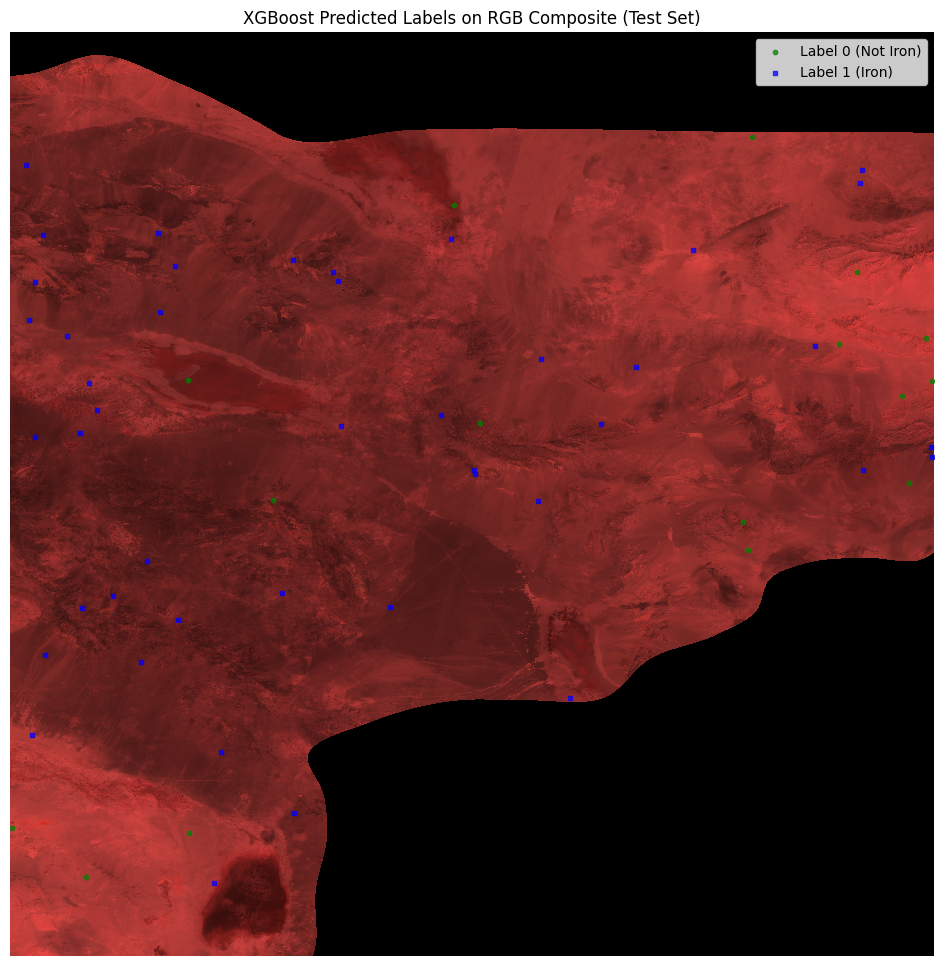

Label 0 count: 16
Label 0 color: green (Not Iron)
Label 1 count: 44
Label 1 color: Blue (Iron)


In [8]:
# Create a mask for the predicted labels
predicted_mask = np.zeros_like(non_zero_mask, dtype=int)
for idx, coord in enumerate(test_idx):
    predicted_mask[coord[0], coord[1]] = y_pred[idx] + 1  # Use 1-based index for visualization

# Plot the transposed image with predicted labels for the test set
plt.figure(figsize=(12, 12))

# Show the image with a red RGB composite (assuming you have red, green, and blue bands)
plt.imshow(image_rgb_uint8, interpolation='none')  # Display red composite

# Overlay the predicted labels with different colors and shapes
for label_id in range(2):
    label_coords = test_idx[y_pred == label_id]
    plt.scatter(label_coords[:, 1], label_coords[:, 0], 
                color=['green', 'blue'][label_id], 
                marker=['o', 's'][label_id],  # Circle and square markers
                label=f'Label {label_id} ({["Not Iron", "Iron"][label_id]})', 
                alpha=0.7, s=10)  # Marker size and transparency

plt.title('XGBoost Predicted Labels on RGB Composite (Test Set)')
plt.legend()
plt.axis('off')  # Hide axis
plt.show()

# Print predicted label counts and colors
predicted_counts = pd.Series(y_pred).value_counts()
colors = ['green', 'Blue']

for label_id in range(2):
    print(f"Label {label_id} count: {predicted_counts.get(label_id, 0)}")
    print(f"Label {label_id} color: {colors[label_id]} ({['Not Iron', 'Iron'][label_id]})")
